# Francesinha Inference with Pretrained Meta-Model (04 + 06 + 07)

Loads a pretrained Logistic Regression meta-model and performs inference/evaluation using base predictions from EfficientNetB0, EfficientNetV2B1, and EfficientNetV2S (PyTorch).

## 1. Imports and Setup

In [ ]:
import os
import sys
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

from sklearn.metrics import log_loss
import joblib

# Resolve project root for utils import
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    PROJECT_ROOT = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    PROJECT_ROOT = cwd
elif (cwd / "cifar10_project").is_dir():
    PROJECT_ROOT = cwd / "cifar10_project"
else:
    PROJECT_ROOT = cwd

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from utils.ml_utils import (
    normalize_splits,
    compute_classification_metrics,
    build_classification_report,
    compute_confusion_matrix,
    plot_confusion_matrix_notebook01,
    apply_notebook01_plot_style,
    log_metrics_to_csv,
    format_duration,
)

# CUDA dynamic libs workaround for mixed TF/PyTorch in Linux/WSL
if sys.platform.startswith("linux") and "VIRTUAL_ENV" in os.environ:
    py_ver = f"python{sys.version_info.major}.{sys.version_info.minor}"
    site_packages = Path(os.environ["VIRTUAL_ENV"]) / "lib" / py_ver / "site-packages"
    nvidia_lib_dirs = [str(path) for path in (site_packages / "nvidia").glob("*/lib") if path.is_dir()]
    if nvidia_lib_dirs:
        previous = os.environ.get("LD_LIBRARY_PATH", "")
        os.environ["LD_LIBRARY_PATH"] = ":".join(nvidia_lib_dirs + ([previous] if previous else []))

print("TF:", tf.__version__)
print("Torch:", torch.__version__)
print("Project root:", PROJECT_ROOT)

TF: 2.16.1
Torch: 2.5.1+cpu
Project root: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project


## 2. Paths and Data

In [ ]:
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    PROJECT_ROOT = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    PROJECT_ROOT = cwd
elif (cwd / "cifar10_project").is_dir():
    PROJECT_ROOT = cwd / "cifar10_project"
else:
    PROJECT_ROOT = cwd

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
IMAGES_DIR = PROJECT_ROOT / "images"
FRANCESINHA_DATA_DIR = DATA_DIR / "francesinha"

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
FRANCESINHA_DATA_DIR.mkdir(parents=True, exist_ok=True)

data_path = PROCESSED_DIR / "cifar10_processed.npz"
performance_report_path = DATA_DIR / "model_performance_report.csv"

model_04_path = MODELS_DIR / "efficientnetb0_cifar10_tuned.keras"
model_06_path = MODELS_DIR / "EfficientNetV2B1_cifar10_tuned.keras"
model_07_path = MODELS_DIR / "efficientnetv2s_cifar10_tuned.pt"

for model_path in [model_04_path, model_06_path, model_07_path]:
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found: {model_path}")

data = np.load(data_path)
x_train = data["x_train"].astype(np.float32)
y_train = np.squeeze(data["y_train"]).astype(np.int64)
x_val = data["x_val"].astype(np.float32)
y_val = np.squeeze(data["y_val"]).astype(np.int64)
x_test = data["x_test"].astype(np.float32)
y_test = np.squeeze(data["y_test"]).astype(np.int64)

raw_max = float(max(x_train.max(), x_val.max(), x_test.max()))
if raw_max > 1.5:
    splits = normalize_splits({
        "x_train": x_train,
        "x_val": x_val,
        "x_test": x_test,
    }, scale=255.0, dtype="float32", clip_range=(0.0, 1.0))
    x_train, x_val, x_test = splits["x_train"], splits["x_val"], splits["x_test"]
    print("Applied normalization from [0,255] to [0,1].")
else:
    print("Data already in [0,1]. Skipping extra normalization.")

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
num_classes = len(class_names)

print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

Data already in [0,1]. Skipping extra normalization.
x_val: (10000, 32, 32, 3) y_val: (10000,)
x_test: (10000, 32, 32, 3) y_test: (10000,)
x ranges: train[0.0000,1.0000] val[0.0000,1.0000] test[0.0000,1.0000]


## 3. Load the 3 Base Models

In [3]:
# Keras models (04, 06)
model_04 = tf.keras.models.load_model(model_04_path, safe_mode=False, compile=False)
model_06 = tf.keras.models.load_model(model_06_path, safe_mode=False, compile=False)

def resolve_keras_image_size(model, fallback=96):
    shape = getattr(model, "input_shape", None)
    if isinstance(shape, list):
        shape = shape[0]
    if shape is None or len(shape) < 3 or shape[1] is None:
        return fallback
    return int(shape[1])

IMG_04 = resolve_keras_image_size(model_04, fallback=96)
IMG_06 = resolve_keras_image_size(model_06, fallback=128)

# PyTorch model (07)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_torch_v2s(num_classes=10):
    net = models.efficientnet_v2_s(weights=None)
    in_features = net.classifier[1].in_features
    net.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes),
    )
    return net

model_07 = build_torch_v2s(num_classes=num_classes)
checkpoint_07 = torch.load(model_07_path, map_location=device)
state_dict = checkpoint_07.get("model_state_dict", checkpoint_07)
model_07.load_state_dict(state_dict, strict=True)
model_07 = model_07.to(device)
model_07.eval()

print(f"Model 04 input size: {IMG_04}")
print(f"Model 06 input size: {IMG_06}")
print("Model 07 loaded on:", device)

2026-02-20 09:32:43.854489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 09:32:43.973363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 09:32:43.973415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 09:32:43.974962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 09:32:43.975004: I external/local_xla/xla/stream_executor

Model 04 input size: 96
Model 06 input size: 96
Model 07 loaded on: cpu


## 4. Inference Functions and Meta-Features

In [4]:
def predict_proba_keras(model, x, image_size, batch_size=128):
    x_resized = tf.image.resize(x, (image_size, image_size)).numpy()
    probs = model.predict(x_resized, batch_size=batch_size, verbose=0)
    return np.asarray(probs, dtype=np.float32)

class CifarTorchEvalDataset(Dataset):
    def __init__(self, images, labels, image_size=96):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).permute(2, 0, 1).float()
        image = self.transform(image)
        label = int(self.labels[idx])
        return image, label

def predict_proba_torch(model, x, y, image_size=96, batch_size=128):
    dataset = CifarTorchEvalDataset(x, y, image_size=image_size)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    all_probs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)

    return np.concatenate(all_probs, axis=0).astype(np.float32)

def build_meta_features(p1, p2, p3):
    return np.concatenate([p1, p2, p3], axis=1).astype(np.float32)

## 5. Generate Base Predictions and Load Pretrained Meta-Classifier

In [5]:
start_time = time.time()

# Test probabilities (inference pipeline)
p04_test = predict_proba_keras(model_04, x_test, image_size=IMG_04)
p06_test = predict_proba_keras(model_06, x_test, image_size=IMG_06)
p07_test = predict_proba_torch(model_07, x_test, y_test, image_size=96)

print("Pred shapes (test):", p04_test.shape, p06_test.shape, p07_test.shape)

if not (len(p04_test) == len(p06_test) == len(p07_test) == len(y_test)):
    raise ValueError(
        f"Prediction size mismatch: p04={len(p04_test)}, p06={len(p06_test)}, p07={len(p07_test)}, y_test={len(y_test)}"
    )

X_meta_test = build_meta_features(p04_test, p06_test, p07_test)

meta_model_path = MODELS_DIR / "francesinha_meta_logreg.joblib"
if not meta_model_path.exists():
    raise FileNotFoundError(
        f"Pretrained meta-model not found: {meta_model_path}. Run notebook 08 meta-training first."
    )
meta_model = joblib.load(meta_model_path)
print("Loaded pretrained meta-model from:", meta_model_path)

francesinha_probs_test = meta_model.predict_proba(X_meta_test)
francesinha_pred_test = np.argmax(francesinha_probs_test, axis=1)

# Base model predictions for comparison
pred04_test = np.argmax(p04_test, axis=1)
pred06_test = np.argmax(p06_test, axis=1)
pred07_test = np.argmax(p07_test, axis=1)

elapsed_sec = time.time() - start_time
print("Meta feature shape:", X_meta_test.shape)
print(f"Inference pipeline time: {elapsed_sec:.2f} sec")

I0000 00:00:1771579977.725045   27580 service.cc:145] XLA service 0x7bde7c003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771579977.725856   27580 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-02-20 09:32:57.812753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-20 09:32:58.188463: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1771579978.663201   27756 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2032', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1771579978.734155   27762 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2032', 228 bytes spill stores, 228 bytes spill loads

2026-

Pred shapes (test): (10000, 10) (10000, 10) (10000, 10)
Loaded pretrained meta-model from: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/francesinha_meta_logreg.joblib
Meta feature shape: (10000, 30)
Inference pipeline time: 70.43 sec


## 6. Metrics and Reports

In [6]:
metrics_04 = compute_classification_metrics(y_test, pred04_test, average="macro")
metrics_06 = compute_classification_metrics(y_test, pred06_test, average="macro")
metrics_07 = compute_classification_metrics(y_test, pred07_test, average="macro")
metrics_francesinha = compute_classification_metrics(y_test, francesinha_pred_test, average="macro")

print("=== Classification Report: Francesinha ===")
print(build_classification_report(y_test, francesinha_pred_test, target_names=class_names, digits=4))

results_df = pd.DataFrame([
    {"model": "EfficientNetB0 (04)", **metrics_04},
    {"model": "EfficientNetV2B1 (06)", **metrics_06},
    {"model": "EfficientNetV2S (07)", **metrics_07},
    {"model": "Francesinha Meta (LR)", **metrics_francesinha},
])
display(results_df)

=== Classification Report: Francesinha ===
              precision    recall  f1-score   support

    airplane     0.9801    0.9850    0.9825      1000
  automobile     0.9742    0.9820    0.9781      1000
        bird     0.9671    0.9690    0.9680      1000
         cat     0.9329    0.9310    0.9319      1000
        deer     0.9672    0.9720    0.9696      1000
         dog     0.9393    0.9290    0.9341      1000
        frog     0.9830    0.9840    0.9835      1000
       horse     0.9819    0.9790    0.9805      1000
        ship     0.9871    0.9910    0.9890      1000
       truck     0.9808    0.9720    0.9764      1000

    accuracy                         0.9694     10000
   macro avg     0.9694    0.9694    0.9694     10000
weighted avg     0.9694    0.9694    0.9694     10000



,model,accuracy,precision,recall,f1,support
0,EfficientNetB0 (04),0.9538,0.953530,0.9538,0.953584,10000
1,EfficientNetV2B1 (06),0.9513,0.951177,0.9513,0.951043,10000
2,EfficientNetV2S (07),0.9549,0.955047,0.9549,0.954819,10000
3,Francesinha Meta (LR),0.9694,0.969358,0.9694,0.969370,10000


## 7. Plots

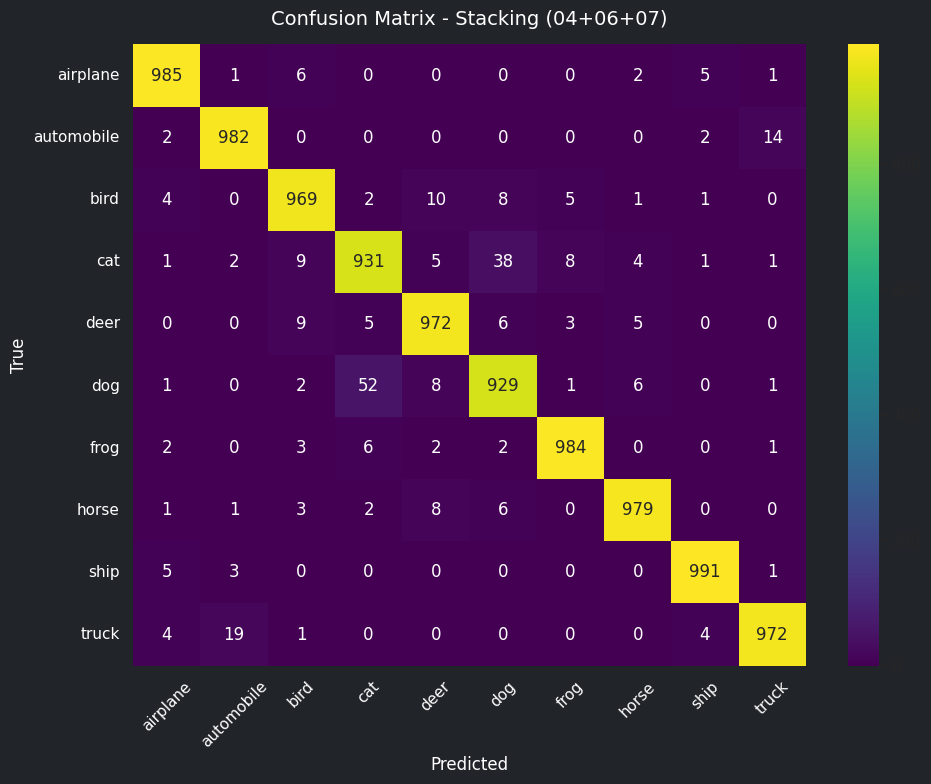

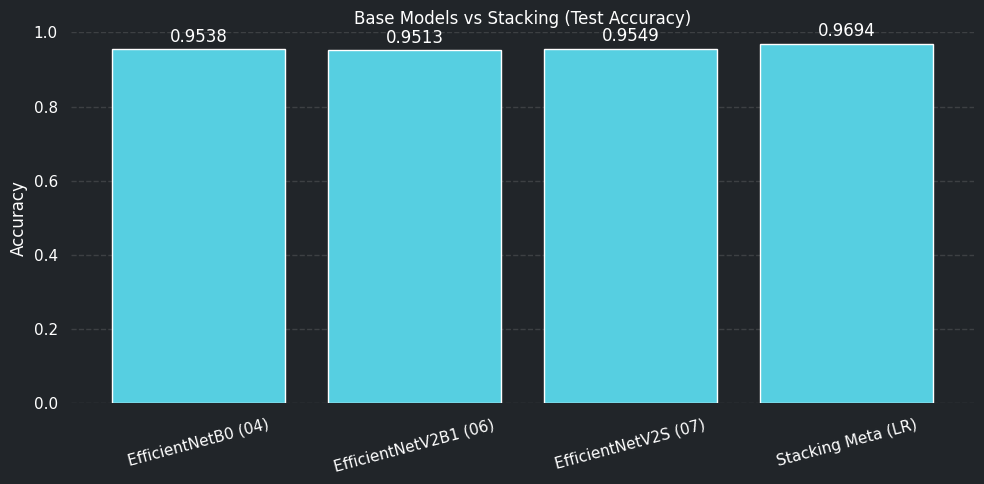

Saved confusion matrix to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/francesinha_confusion_matrix.png
Saved comparison chart to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/francesinha_accuracy_comparison.png


In [ ]:
cm_francesinha = compute_confusion_matrix(y_test, francesinha_pred_test)
conf_path = IMAGES_DIR / "francesinha_confusion_matrix.png"
plot_confusion_matrix_notebook01(
    confusion=cm_francesinha,
    class_names=class_names,
    title="Confusion Matrix - Francesinha (04+06+07)",
    save_path=conf_path,
    dpi=300,
)

fig, ax = plt.subplots(figsize=(10, 5))
apply_notebook01_plot_style(fig, ax, grid_axis="y")
bars = ax.bar(results_df["model"], results_df["accuracy"], color="#56cfe1")
ax.set_ylabel("Accuracy")
ax.set_title("Base Models vs Francesinha (Test Accuracy)")
ax.set_ylim(0, 1.0)
ax.tick_params(axis="x", rotation=15)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.01,
        f"{h:.4f}",
        ha="center",
        va="bottom",
        color="white",
    )

acc_path = IMAGES_DIR / "francesinha_accuracy_comparison.png"
plt.tight_layout()
plt.savefig(acc_path, dpi=300)
plt.show()

print("Saved confusion matrix to:", conf_path)
print("Saved comparison chart to:", acc_path)

## 8. Logging and Persistence

In [ ]:
francesinha_logloss = float(log_loss(y_test, francesinha_probs_test, labels=np.arange(num_classes)))
meta_num_params = int(meta_model.coef_.size + meta_model.intercept_.size)

row = {
    "model_name": "Francesinha Inference (Pretrained Meta LR: EffB0+EffV2B1+EffV2S)",
    "num_params": meta_num_params,
    "train_time_sec": float(round(elapsed_sec, 2)),
    "train_time": format_duration(elapsed_sec),
    "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
    "accuracy": float(metrics_francesinha["accuracy"]),
    "precision": float(metrics_francesinha["precision"]),
    "recall": float(metrics_francesinha["recall"]),
    "f1": float(metrics_francesinha["f1"]),
    "support": int(metrics_francesinha["support"]),
    "final_accuracy": None,
    "final_loss": None,
    "final_val_accuracy": None,
    "final_val_loss": None,
    "final_learning_rate": None,
    "epochs_trained": None,
    "test_loss": francesinha_logloss,
    "framework": "francesinha_inference_pretrained_meta",
}

_ = log_metrics_to_csv(performance_report_path, row, append=True)
print("Logged row:")
print(row)

meta_features_path = FRANCESINHA_DATA_DIR / "francesinha_meta_features_test_inference.npz"
np.savez_compressed(
    meta_features_path,
    X_meta_test=X_meta_test,
    y_test=y_test,
    francesinha_probs_test=francesinha_probs_test,
    francesinha_pred_test=francesinha_pred_test,
)

print("Using pretrained meta-model:", meta_model_path)
print("Saved meta features to:", meta_features_path)

Logged row:
{'model_name': 'Francesinha Inference (Pretrained Meta LR: EffB0+EffV2B1+EffV2S)', 'num_params': 310, 'train_time_sec': 70.43, 'train_time': '1 min 10 sec', 'timestamp': '2026-02-20 09:34', 'accuracy': 0.9694, 'precision': 0.9693576350157972, 'recall': 0.9693999999999999, 'f1': 0.9693703687779447, 'support': 10000, 'final_accuracy': None, 'final_loss': None, 'final_val_accuracy': None, 'final_val_loss': None, 'final_learning_rate': None, 'epochs_trained': None, 'test_loss': 0.11614262722155336, 'framework': 'francesinha_inference_pretrained_meta'}
Using pretrained meta-model: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/francesinha_meta_logreg.joblib
Saved meta features to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/francesinha_meta_features_test_inference.npz


/mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/utils/ml_utils.py:268: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([existing, frame], ignore_index=True, sort=False)
